In [25]:
# libs
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.stats import norm, t
from scipy.optimize import minimize


In [ ]:
warnings.filterwarnings('ignore')

In [1]:
pip install yfinance


In [21]:
# tickers
tickers = ["V", "RTX", "LUV"]

# time period according to paper
start_date = "2020-01-01"
end_date = "2023-10-01"
# close prices
raw_data = yf.download(tickers, start=start_date, end=end_date)[['Close']]


[*********************100%***********************]  3 of 3 completed


In [22]:
# drop rows with missing values (e.g., holidays)
raw_data.dropna(inplace=True)
raw_data.columns

MultiIndex([('Close', 'LUV'),
            ('Close', 'RTX'),
            ('Close',   'V')],
           names=['Price', 'Ticker'])

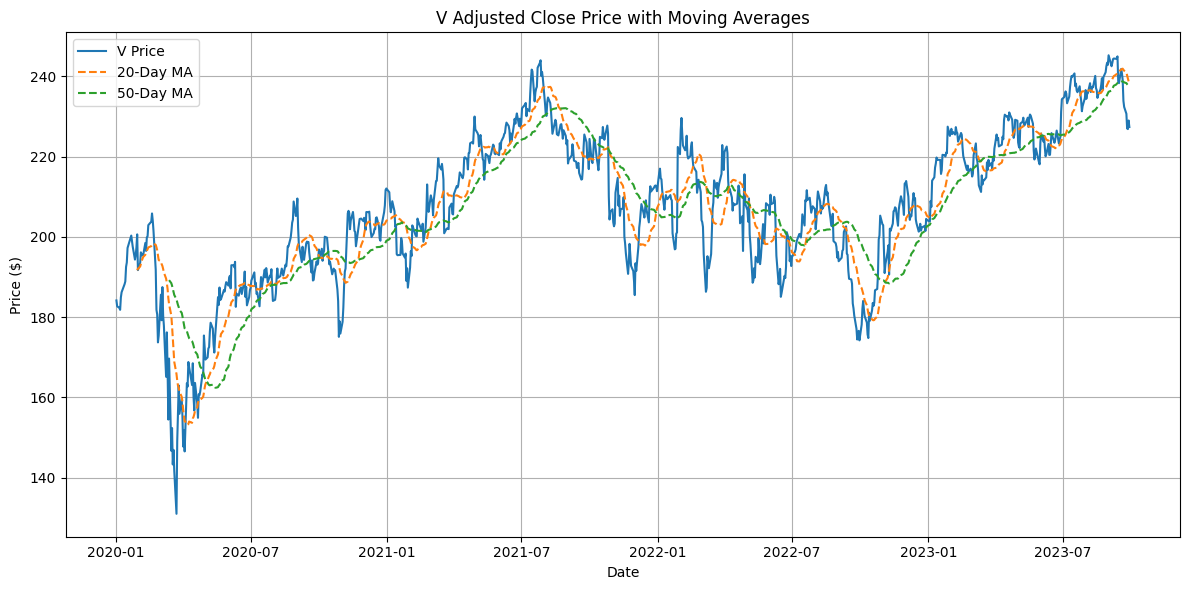

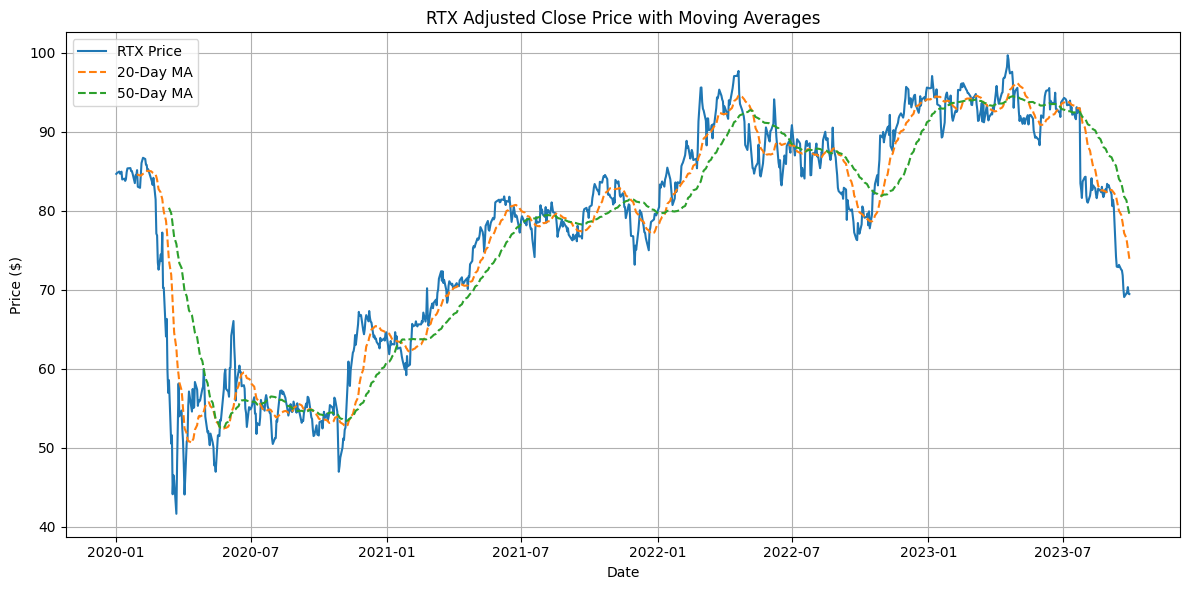

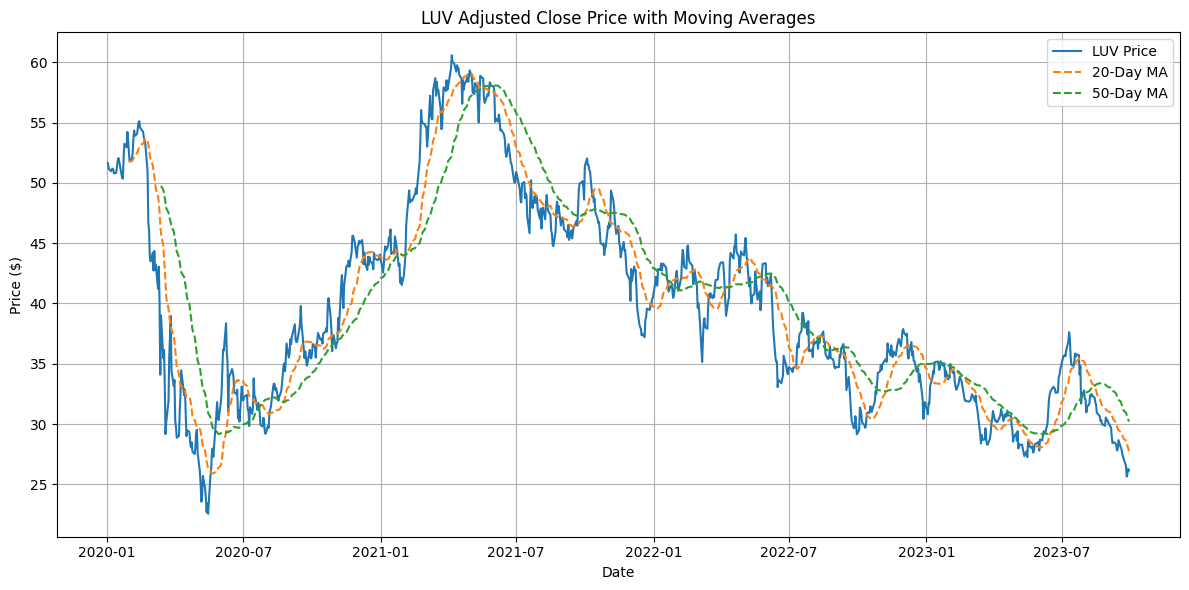

In [23]:
# flatten the column names
data = raw_data['Close']
# data.columns
for ticker in tickers:
    df = data[ticker].copy()

    # moving averages
    ma_20 = df.rolling(window=20).mean()
    ma_50 = df.rolling(window=50).mean()
    ma_200 = df.rolling(window=200).mean()


    plt.figure(figsize=(12, 6))
    plt.plot(df, label=f"{ticker} Price", linewidth=1.5)
    plt.plot(ma_20, label="20-Day MA", linestyle="--")
    plt.plot(ma_50, label="50-Day MA", linestyle="--")
    # plt.plot(ma_200, label="200-Day MA", linestyle="--")
    plt.title(f"{ticker} Adjusted Close Price with Moving Averages")
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [34]:
# daily log returns
# returns = data.pct_change().apply(lambda x: np.log(1 + x)).dropna()
# # plot
# plt.figure(figsize=(14, 6))
# sns.lineplot(data=returns)
# plt.title("Daily Log Returns of V, RTX, and LUV")
# plt.xlabel("Date")
# plt.ylabel("Log Return")
# plt.legend(labels=returns.columns)
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [ ]:
# formation: Jan 2020 – Dec 2022
# trading: Jan 2023 – Oct 2023
formation = returns.loc["2020-01-01":"2022-12-31"]
trading = returns.loc["2023-01-01":"2023-10-01"]



In [38]:
data = yf.download("LUV", start="2020-01-01", end="2023-10-01")["Close"]
returns = np.log(data / data.shift(1)).dropna().values

[*********************100%***********************]  1 of 1 completed


In [39]:
# define the mixture --*
def mixture(x, w, mu1, sigma1, mu2, sigma2, df):
    return w * norm.pdf(x, mu1, sigma1) + (1 - w) * t.pdf(x, df, loc=mu2, scale=sigma2)

# negative log-
def neg_log_likelihood(params, data):
    w, mu1, sigma1, mu2, sigma2, df = params

    if not (0 < w < 1 and sigma1 > 0 and sigma2 > 0 and df > 1):
        return np.inf
    pdf_vals = mixture(data, w, mu1, sigma1, mu2, sigma2, df)
    return -np.sum(np.log(pdf_vals + 1e-10))  # avoids log(0)

✅ Mixture model fitted successfully!
w=0.0421, Normal(μ=-0.0044, σ=0.0035), t(μ=-0.0002, σ=0.0199, df=3.90)


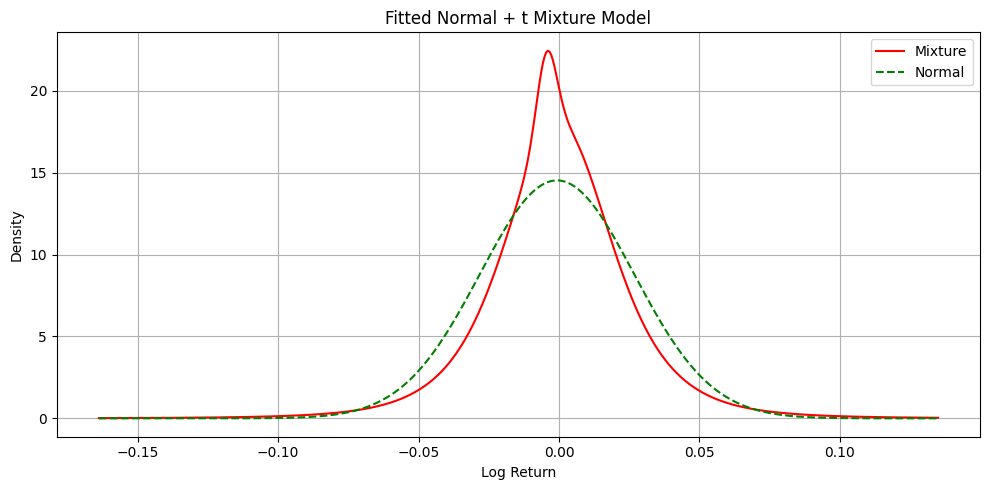

In [40]:

# -- unitial guess and optimization ---
initial_guess = [0.5, 0, 0.01, 0, 0.01, 5]
result = minimize(neg_log_likelihood, initial_guess, args=(returns,), method="L-BFGS-B",
                  bounds=[(0.01, 0.99), (-1, 1), (1e-6, 1), (-1, 1), (1e-6, 1), (1.01, 30)])

if result.success:
    w, mu1, sigma1, mu2, sigma2, df = result.x
    print("mixture model fitted successfully")
    print(f"w={w:.4f}, Normal(μ={mu1:.4f}, σ={sigma1:.4f}), t(μ={mu2:.4f}, σ={sigma2:.4f}, df={df:.2f})")
else:
    print("failed")

# --plot ---

# get normal-only MLE fit (for comparison)
mu_norm, std_norm = np.mean(returns), np.std(returns)

x_vals = np.linspace(np.min(returns), np.max(returns), 500)
mixture_vals = mixture(x_vals, w, mu1, sigma1, mu2, sigma2, df)
normal_vals = norm.pdf(x_vals, mu_norm, std_norm)

plt.figure(figsize=(10, 5))
# sns.histplot(returns, bins=50, kde=False, stat='density', color='skyblue', label='Empirical')
plt.plot(x_vals, mixture_vals, 'r-', label='Mixture')
# plt.plot(x)
plt.plot(x_vals, normal_vals, 'g--', label='Normal')
plt.title("Fitted Normal + t Mixture Model")
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# fits your return data to a weighted combo of a normal and a t-distribution

# Estimates 6 parameters:
# w, μ₁, σ₁ (normal)
# μ₂, σ₂, df (t-distribution)

# histogram of the actual returns + the fitted curve